# **Section A — Environment & Drive Setup**

# Install Libraries & Set Random Seeds

In [ ]:
!pip install -U tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is inc

In [ ]:
!pip -q install shap

import os, random, json, math, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

import shap
warnings.filterwarnings("ignore")

# Fix seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Environment setup complete")


✅ Environment setup complete


## Mount Google Drive & Create Folder Structure

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Base project path in Google Drive
BASE = Path("/content/drive/MyDrive/FitMatchAI")

# Create folder structure
for p in ["data/raw","data/interim","data/processed","artifacts","reports"]:
    (BASE / p).mkdir(parents=True, exist_ok=True)

print("📂 Project folders ready:")
for p in (BASE).iterdir():
    if p.is_dir():
        print(" -", p)


Mounted at /content/drive
📂 Project folders ready:
 - /content/drive/MyDrive/FitMatchAI/data
 - /content/drive/MyDrive/FitMatchAI/artifacts
 - /content/drive/MyDrive/FitMatchAI/reports
 - /content/drive/MyDrive/FitMatchAI/models


# **Section B — Data (Scope, Sources)**

# Unzip Files and DataSet Configuration

In [ ]:
# Unzip all files in data/raw ---

import zipfile

raw_path = BASE / "data/raw"

# Unzip any .zip files inside data/raw
for zip_file in raw_path.glob("*.zip"):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(raw_path)
    print(f"✅ Unzipped {zip_file.name}")

print("\n📂 Files now available in data/raw:")
for f in raw_path.glob("*"):
    print(" -", f.name)


# Dataset Configuration ---

CONFIG = {
    "fitlife": str(BASE/"data/raw/health_fitness_dataset.csv"),        # FitLife dataset
    "gym_members": None,  # Not found yet - maybe included in health_fitness_dataset? we'll inspect
    "workout_tracker": str(BASE/"data/raw/workout_fitness_tracker_data.csv"),
    "megagym": str(BASE/"data/raw/megaGymDataset.csv"),
    "recipes": str(BASE/"data/raw/recipes.csv"),   # optional nutrition
    "reviews": str(BASE/"data/raw/reviews.csv")    # optional, likely linked to recipes
}

print("🔧 Dataset paths set:")
for k,v in CONFIG.items():
    print(f"{k:15s} → {v}")



✅ Unzipped gym workout dataset.zip
✅ Unzipped FitLife Dataset.zip
✅ Unzipped Workout and Fitness tracker dataset.zip
✅ Unzipped Physical Activity Prediction Dataset.zip
✅ Unzipped archive (4).zip

📂 Files now available in data/raw:
 - gym workout dataset.zip
 - dailyActivity_merged.csv
 - dataset2.csv
 - FitLife Dataset.zip
 - sleepDay_merged.csv
 - Workout and Fitness tracker dataset.zip
 - recipes.parquet
 - health_fitness_dataset.csv
 - reviews.parquet
 - Physical Activity Prediction Dataset.zip
 - dataset_uci
 - MHEALTHDATASET
 - Still exp
 - reviews.csv
 - archive (4).zip
 - recipes.csv
 - Activity recognition exp
 - gym workout dataset
 - FitLife Dataset
 - Workout and Fitness tracker dataset
 - Physical Activity Prediction Dataset
 - archive (4)
 - megaGymDataset.csv
 - workout_fitness_tracker_data.csv
🔧 Dataset paths set:
fitlife         → /content/drive/MyDrive/FitMatchAI/data/raw/health_fitness_dataset.csv
gym_members     → None
workout_tracker → /content/drive/MyDrive/FitMat

## Preview Extracted CSVs

In [ ]:

def preview_csvs(config, n=5):
    for name, path in config.items():
        if path is None:
            print(f"\n⚠️ Skipping {name}: no file assigned yet")
            continue
        try:
            df = pd.read_csv(path)
            print(f"\n📄 Dataset: {name} ({path}) → shape {df.shape}")
            display(df.head(n))
        except Exception as e:
            print(f"⚠️ Could not load {name}: {e}")

preview_csvs(CONFIG, n=5)



📄 Dataset: fitlife (/content/drive/MyDrive/FitMatchAI/data/raw/health_fitness_dataset.csv) → shape (687701, 22)


,participant_id,date,age,gender,height_cm,weight_kg,activity_type,duration_minutes,intensity,calories_burned,...,stress_level,daily_steps,hydration_level,bmi,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,health_condition,smoking_status,fitness_level
0,1,2024-01-01,56,F,165.3,53.7,Dancing,41,Low,3.3,...,3,7128,1.5,19.6,69.5,110.7,72.9,NaN,Never,0.04
1,1,2024-01-04,56,F,165.3,53.9,Swimming,28,Low,2.9,...,7,7925,1.8,19.6,69.5,110.7,72.9,NaN,Never,0.07
2,1,2024-01-05,56,F,165.3,54.2,Swimming,21,Medium,2.6,...,7,7557,2.7,19.6,69.5,110.7,72.9,NaN,Never,0.09
3,1,2024-01-07,56,F,165.3,54.4,Weight Training,99,Medium,10.7,...,8,11120,2.6,19.6,69.5,110.7,72.9,NaN,Never,0.21
4,1,2024-01-09,56,F,165.3,54.7,Swimming,100,Medium,12.7,...,1,5406,1.5,19.6,69.5,110.7,72.9,NaN,Never,0.33



⚠️ Skipping gym_members: no file assigned yet

📄 Dataset: workout_tracker (/content/drive/MyDrive/FitMatchAI/data/raw/workout_fitness_tracker_data.csv) → shape (10000, 20)


,User ID,Age,Gender,Height (cm),Weight (kg),Workout Type,Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,Distance (km),Workout Intensity,Sleep Hours,Water Intake (liters),Daily Calories Intake,Resting Heart Rate (bpm),VO2 Max,Body Fat (%),Mood Before Workout,Mood After Workout
0,1,39,Male,175,99,Cycling,79,384,112,8850,14.44,High,8.2,1.9,3195,61,38.4,28.5,Tired,Fatigued
1,2,36,Other,157,112,Cardio,73,612,168,2821,1.10,High,8.6,1.9,2541,73,38.4,28.5,Happy,Energized
2,3,25,Female,180,66,HIIT,27,540,133,18898,7.28,High,9.8,1.9,3362,80,38.4,28.5,Happy,Fatigued
3,4,56,Male,154,89,Cycling,39,672,118,14102,6.55,Medium,5.8,1.9,2071,65,38.4,28.5,Neutral,Neutral
4,5,53,Other,194,59,Strength,56,410,170,16518,3.17,Medium,7.3,1.9,3298,59,38.4,28.5,Stressed,Energized



📄 Dataset: megagym (/content/drive/MyDrive/FitMatchAI/data/raw/megaGymDataset.csv) → shape (2918, 9)


,Unnamed: 0,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,NaN
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,NaN,NaN



📄 Dataset: recipes (/content/drive/MyDrive/FitMatchAI/data/raw/recipes.csv) → shape (522517, 28)


,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."



📄 Dataset: reviews (/content/drive/MyDrive/FitMatchAI/data/raw/reviews.csv) → shape (1401982, 8)


,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [ ]:
raw_csvs = list((BASE/"data/raw").glob("*.csv"))

print("📂 CSV files currently in data/raw:")
for f in raw_csvs:
    print(" -", f.name)


📂 CSV files currently in data/raw:
 - dailyActivity_merged.csv
 - dataset2.csv
 - sleepDay_merged.csv
 - health_fitness_dataset.csv
 - reviews.csv
 - recipes.csv
 - megaGymDataset.csv
 - workout_fitness_tracker_data.csv


## B9: Activity Type Mapping

In [ ]:

ACTIVITY_MAP = {
    # --- Cardio ---
    "Running": "cardio",
    "Jogging": "cardio",
    "Walking": "cardio",
    "Cycling": "cardio",
    "Swimming": "cardio",
    "Rowing": "cardio",
    "Dancing": "cardio",
    "Cardio": "cardio",
    "Aerobics": "cardio",

    # --- Strength ---
    "Strength": "strength",
    "Weight Training": "strength",
    "Powerlifting": "strength",
    "Bodyweight": "strength",
    "Resistance Training": "strength",
    "CrossFit": "strength",

    # --- HIIT / Mixed ---
    "HIIT": "hiit",
    "Circuit Training": "hiit",
    "Bootcamp": "hiit",

    # --- Recovery ---
    "Yoga": "recovery",
    "Meditation": "recovery",
    "Stretching": "recovery",
    "Pilates": "recovery",
    "Mobility": "recovery",
    "Breathing Exercises": "recovery",
}

def map_activity(activity):
    """Maps raw activity_type/Workout Type to {cardio, strength, hiit, recovery, other}"""
    if activity in ACTIVITY_MAP:
        return ACTIVITY_MAP[activity]
    return "other"

# Example usage
print(map_activity("Swimming"))      # cardio
print(map_activity("Weight Training")) # strength
print(map_activity("HIIT"))          # hiit
print(map_activity("Yoga"))          # recovery
print(map_activity("Zumba"))         # other


cardio
strength
hiit
recovery
other


## B10: Weekly Aggregation & Schema Unification

## FitLife

In [ ]:

def preprocess_fitlife(path):
    """
    Preprocess the FitLife dataset:
    - Standardize column names
    - Map activities to cardio/strength/hiit/recovery
    - Aggregate per user-week
    - Create labels: weight delta + action classification
    """

    # Load CSV
    df = pd.read_csv(path)

    # --- Standardize column names ---
    df = df.rename(columns={
        "participant_id": "user_id",
        "gender": "sex",
        "height_cm": "height_cm",
        "weight_kg": "weight_kg",
        "bmi": "bmi",
        "activity_type": "activity",
        "duration_minutes": "duration",
        "calories_burned": "calories",
        "date": "date"
    })

    # Convert date to datetime
    df["date"] = pd.to_datetime(df["date"])

    # Map activities to categories
    df["activity_category"] = df["activity"].apply(map_activity)

    # Assign week index per user (dense rank by date, floored to week blocks)
    df["week_idx"] = df.groupby("user_id")["date"].rank(method="dense").astype(int) // 7

    # --- Weekly aggregation ---
    weekly = df.groupby(["user_id","week_idx"]).agg(
        age=("age","first"),
        sex=("sex","first"),
        height_cm=("height_cm","first"),
        weight_kg=("weight_kg","last"),
        bmi=("bmi","last"),
        workouts_done=("activity","count"),
        avg_session_minutes=("duration","mean"),
        total_minutes=("duration","sum"),
        calories_burned=("calories","sum"),
        cardio_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="cardio"].sum()),
        strength_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="strength"].sum()),
        hiit_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="hiit"].sum()),
        recovery_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="recovery"].sum()),
        stress_level=("stress_level","mean"),
        daily_steps=("daily_steps","mean"),
        hydration_level=("hydration_level","mean"),
        resting_heart_rate=("resting_heart_rate","mean"),
    ).reset_index()

    # --- Create labels ---
    weekly["label_next_weight_delta"] = (
        weekly.groupby("user_id")["weight_kg"].shift(-1) - weekly["weight_kg"]
    )

    def classify_action(delta):
        if pd.isna(delta): return None
        if delta < -0.2: return "increase"   # user losing weight → increase load
        elif delta > 0.2: return "decrease"  # user gaining weight → decrease load
        else: return "maintain"

    weekly["label_next_action"] = weekly["label_next_weight_delta"].apply(classify_action)

    return weekly


# --- Run preprocessing on FitLife dataset ---
fitlife_weekly = preprocess_fitlife(CONFIG["fitlife"])

# Save to interim folder
out_path = BASE/"data/interim/fitlife_weekly.parquet"
fitlife_weekly.to_parquet(out_path, index=False)

print(f"✅ Weekly FitLife schema created and saved to {out_path}")
display(fitlife_weekly.head())


✅ Weekly FitLife schema created and saved to /content/drive/MyDrive/FitMatchAI/data/interim/fitlife_weekly.parquet


,user_id,week_idx,age,sex,height_cm,weight_kg,bmi,workouts_done,avg_session_minutes,total_minutes,...,cardio_minutes,strength_minutes,hiit_minutes,recovery_minutes,stress_level,daily_steps,hydration_level,resting_heart_rate,label_next_weight_delta,label_next_action
0,1,0,56,F,165.3,54.9,19.6,6,53.333333,320,...,190,99,31,0,6.000000,8223.000000,2.050000,69.5,1.9,decrease
1,1,1,56,F,165.3,56.8,19.6,7,88.142857,617,...,0,317,300,0,6.714286,9006.428571,2.614286,69.5,1.8,decrease
2,1,2,56,F,165.3,58.6,19.6,7,59.285714,415,...,177,99,139,0,2.857143,8508.000000,2.528571,69.5,1.8,decrease
3,1,3,56,F,165.3,60.4,19.6,7,74.285714,520,...,46,0,242,0,4.857143,9221.571429,2.685714,69.5,1.8,decrease
4,1,4,56,F,165.3,62.2,19.6,7,57.285714,401,...,0,107,0,0,5.142857,10147.142857,2.571429,69.5,1.8,decrease


## Workout Tracker Schema Unification

In [ ]:
def preprocess_tracker(path):
    """
    Preprocess the Workout Tracker dataset:
    - Standardize column names
    - Map workout types to cardio/strength/hiit/recovery
    - Aggregate per user-week
    - Create labels: weight delta + action classification
    """

    # Load CSV
    df = pd.read_csv(path)

    # --- Standardize column names ---
    df = df.rename(columns={
        "User ID": "user_id",
        "Age": "age",
        "Gender": "sex",
        "Height (cm)": "height_cm",
        "Weight (kg)": "weight_kg",
        "Workout Type": "activity",
        "Workout Duration (mins)": "duration",
        "Calories Burned": "calories",
        "Workout Intensity": "intensity",
        "Steps Taken": "steps",
        "Sleep Hours": "sleep_hours",
        "Water Intake (liters)": "water_intake",
        "Daily Calories Intake": "daily_calories",
        "Resting Heart Rate (bpm)": "resting_heart_rate",
        "VO2 Max": "vo2_max",
        "Body Fat (%)": "body_fat_pct",
        "Mood Before Workout": "mood_before",
        "Mood After Workout": "mood_after"
    })

    # Assign a pseudo-date if missing (assuming each row is sequential sessions)
    if "date" not in df.columns:
        df["date"] = pd.date_range("2024-01-01", periods=len(df), freq="D")

    # Map activities to categories
    df["activity_category"] = df["activity"].apply(map_activity)

    # Assign week index per user
    df["week_idx"] = df.groupby("user_id")["date"].rank(method="dense").astype(int) // 7

    # --- Weekly aggregation ---
    weekly = df.groupby(["user_id","week_idx"]).agg(
        age=("age","first"),
        sex=("sex","first"),
        height_cm=("height_cm","first"),
        weight_kg=("weight_kg","last"),
        bmi=("weight_kg", lambda x: x.mean() / ((df["height_cm"].mean()/100) ** 2)),  # rough BMI
        workouts_done=("activity","count"),
        avg_session_minutes=("duration","mean"),
        total_minutes=("duration","sum"),
        calories_burned=("calories","sum"),
        cardio_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="cardio"].sum()),
        strength_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="strength"].sum()),
        hiit_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="hiit"].sum()),
        recovery_minutes=("duration", lambda x: x[df.loc[x.index,"activity_category"]=="recovery"].sum()),
        steps=("steps","mean"),
        sleep_hours=("sleep_hours","mean"),
        water_intake=("water_intake","mean"),
        daily_calories=("daily_calories","mean"),
        resting_heart_rate=("resting_heart_rate","mean"),
        vo2_max=("vo2_max","mean"),
        body_fat_pct=("body_fat_pct","mean"),
    ).reset_index()

    # --- Create labels ---
    weekly["label_next_weight_delta"] = (
        weekly.groupby("user_id")["weight_kg"].shift(-1) - weekly["weight_kg"]
    )

    def classify_action(delta):
        if pd.isna(delta): return None
        if delta < -0.2: return "increase"
        elif delta > 0.2: return "decrease"
        else: return "maintain"

    weekly["label_next_action"] = weekly["label_next_weight_delta"].apply(classify_action)

    return weekly


# --- Run preprocessing on Workout Tracker dataset ---
tracker_weekly = preprocess_tracker(CONFIG["workout_tracker"])

# Save to interim folder
out_path = BASE/"data/interim/tracker_weekly.parquet"
tracker_weekly.to_parquet(out_path, index=False)

print(f"✅ Weekly Tracker schema created and saved to {out_path}")
display(tracker_weekly.head())


✅ Weekly Tracker schema created and saved to /content/drive/MyDrive/FitMatchAI/data/interim/tracker_weekly.parquet


,user_id,week_idx,age,sex,height_cm,weight_kg,bmi,workouts_done,avg_session_minutes,total_minutes,...,recovery_minutes,steps,sleep_hours,water_intake,daily_calories,resting_heart_rate,vo2_max,body_fat_pct,label_next_weight_delta,label_next_action
0,1,0,39,Male,175,99,32.596015,1,79.0,79,...,0,8850.0,8.2,1.9,3195.0,61.0,38.4,28.5,NaN,None
1,2,0,36,Other,157,112,36.876300,1,73.0,73,...,0,2821.0,8.6,1.9,2541.0,73.0,38.4,28.5,NaN,None
2,3,0,25,Female,180,66,21.730677,1,27.0,27,...,0,18898.0,9.8,1.9,3362.0,80.0,38.4,28.5,NaN,None
3,4,0,56,Male,154,89,29.303489,1,39.0,39,...,0,14102.0,5.8,1.9,2071.0,65.0,38.4,28.5,NaN,None
4,5,0,53,Other,194,59,19.425908,1,56.0,56,...,0,16518.0,7.3,1.9,3298.0,59.0,38.4,28.5,NaN,None


## Merging both the datasets: FitLife and Workout Tracker

In [ ]:
# --- Step B.12: Merge FitLife + Tracker into unified weekly schema ---

def merge_fitlife_tracker(fitlife_path, tracker_path):
    """
    Merge FitLife and Workout Tracker weekly schemas:
    - Align common columns
    - Concatenate into one canonical table
    - Fill missing columns with NaN where dataset doesn't provide them
    """
    # Load weekly datasets
    fitlife = pd.read_parquet(fitlife_path)
    tracker = pd.read_parquet(tracker_path)

    # Canonical column set (union of both)
    canonical_cols = set(fitlife.columns) | set(tracker.columns)

    # Ensure both have all columns
    for col in canonical_cols:
        if col not in fitlife.columns:
            fitlife[col] = np.nan
        if col not in tracker.columns:
            tracker[col] = np.nan

    # Align order
    fitlife = fitlife[sorted(canonical_cols)]
    tracker = tracker[sorted(canonical_cols)]

    # Concatenate
    unified = pd.concat([fitlife, tracker], ignore_index=True)

    # Sort for readability
    unified = unified.sort_values(by=["user_id","week_idx"]).reset_index(drop=True)

    return unified


# --- Run merge ---
unified_weekly = merge_fitlife_tracker(
    BASE/"data/interim/fitlife_weekly.parquet",
    BASE/"data/interim/tracker_weekly.parquet"
)

# Save unified dataset
out_path = BASE/"data/interim/unified_weekly.parquet"
unified_weekly.to_parquet(out_path, index=False)

print(f"✅ Unified weekly schema created and saved to {out_path}")
print("📊 Shape:", unified_weekly.shape)
display(unified_weekly.head())

✅ Unified weekly schema created and saved to /content/drive/MyDrive/FitMatchAI/data/interim/unified_weekly.parquet
📊 Shape: (109990, 27)


,age,avg_session_minutes,bmi,body_fat_pct,calories_burned,cardio_minutes,daily_calories,daily_steps,height_cm,hiit_minutes,...,steps,strength_minutes,stress_level,total_minutes,user_id,vo2_max,water_intake,week_idx,weight_kg,workouts_done
0,56,53.333333,19.600000,NaN,39.0,190,NaN,8223.000000,165.3,31,...,NaN,99,6.000000,320,1,NaN,NaN,0,54.9,6
1,39,79.000000,32.596015,28.5,384.0,79,3195.0,NaN,175.0,0,...,8850.0,0,NaN,79,1,38.4,1.9,0,99.0,1
2,56,88.142857,19.600000,NaN,101.4,0,NaN,9006.428571,165.3,300,...,NaN,317,6.714286,617,1,NaN,NaN,1,56.8,7
3,56,59.285714,19.600000,NaN,71.9,177,NaN,8508.000000,165.3,139,...,NaN,99,2.857143,415,1,NaN,NaN,2,58.6,7
4,56,74.285714,19.600000,NaN,103.5,46,NaN,9221.571429,165.3,242,...,NaN,0,4.857143,520,1,NaN,NaN,3,60.4,7


## Integrating the MegaGym Dataset with the Combined above dataset

In [ ]:
# --- Step B.13 (Corrected): MegaGym Integration ---

def integrate_megagym(unified_path, megagym_path):
    """
    Enrich unified weekly dataset with exercise taxonomy from MegaGym:
    - Use placeholder activity field if missing
    - Map to difficulty and muscle groups
    - Add avg_difficulty_performed & exercise_profile
    """

    # Load unified weekly dataset
    unified = pd.read_parquet(unified_path)

    # Load MegaGym taxonomy
    megagym = pd.read_csv(megagym_path)
    megagym = megagym.rename(columns={
        "Title": "exercise_name",
        "BodyPart": "muscle_group",
        "Level": "difficulty_level"
    })
    megagym["exercise_name"] = megagym["exercise_name"].str.lower().str.strip()

    # --- Ensure activity column exists ---
    if "activity" not in unified.columns:
        unified["activity"] = "generic_workout"

    # Merge unified weekly with MegaGym taxonomy
    merged = pd.merge(
        unified,
        megagym[["exercise_name","muscle_group","difficulty_level"]],
        left_on="activity", right_on="exercise_name", how="left"
    )

    # Difficulty scoring
    difficulty_map = {"beginner":1, "intermediate":2, "advanced":3}
    merged["difficulty_score"] = merged["difficulty_level"].map(
        lambda x: difficulty_map.get(str(x).lower(), np.nan)
    )

    # --- Add enrichment columns ---
    merged["avg_difficulty_performed"] = merged.groupby(["user_id","week_idx"])["difficulty_score"].transform("mean")

    def profile_func(series):
        counts = series.value_counts(normalize=True).to_dict()
        return counts if len(counts)>0 else {}
    merged["exercise_profile"] = merged.groupby(["user_id","week_idx"])["muscle_group"].transform(profile_func)

    merged["experience_level"] = merged.groupby(["user_id","week_idx"])["difficulty_level"].transform(
        lambda x: pd.Series(x).mode()[0] if len(x.dropna())>0 else None
    )

    # Drop duplicates (back to weekly grain)
    enriched = merged.drop_duplicates(subset=["user_id","week_idx"]).reset_index(drop=True)

    return enriched


# --- Run integration ---
enriched_weekly = integrate_megagym(
    BASE/"data/interim/unified_weekly.parquet",
    CONFIG["megagym"]
)

# Save enriched dataset
out_path = BASE/"data/processed/enriched_weekly.parquet"
enriched_weekly.to_parquet(out_path, index=False)

print(f"✅ Enriched weekly schema created and saved to {out_path}")
print("📊 Shape:", enriched_weekly.shape)
display(enriched_weekly.head())


✅ Enriched weekly schema created and saved to /content/drive/MyDrive/FitMatchAI/data/processed/enriched_weekly.parquet
📊 Shape: (106990, 35)


,age,avg_session_minutes,bmi,body_fat_pct,calories_burned,cardio_minutes,daily_calories,daily_steps,height_cm,hiit_minutes,...,weight_kg,workouts_done,activity,exercise_name,muscle_group,difficulty_level,difficulty_score,avg_difficulty_performed,exercise_profile,experience_level
0,56,53.333333,19.6,NaN,39.0,190,NaN,8223.000000,165.3,31,...,54.9,6,generic_workout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,88.142857,19.6,NaN,101.4,0,NaN,9006.428571,165.3,300,...,56.8,7,generic_workout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56,59.285714,19.6,NaN,71.9,177,NaN,8508.000000,165.3,139,...,58.6,7,generic_workout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56,74.285714,19.6,NaN,103.5,46,NaN,9221.571429,165.3,242,...,60.4,7,generic_workout,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,56,57.285714,19.6,NaN,54.8,0,NaN,10147.142857,165.3,0,...,62.2,7,generic_workout,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Section C (Data Cleaning & Feature Engineering)**

In [ ]:
# ============================
# Section C — Data Cleaning & Feature Engineering (v5)
# ============================

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path("/content/drive/MyDrive/FitMatchAI")

RAW_PATH = BASE / "data/processed/enriched_weekly.parquet"
CLEANED_RAW_PATH = BASE / "data/processed/enriched_weekly_cleaned_raw.parquet"
STD_PATH = BASE / "data/processed/enriched_weekly_cleaned_std.parquet"
FEATURES_PATH = BASE / "data/processed/enriched_weekly_cleaned_raw_features.parquet"


# ============================================================
# 1️⃣ Data Cleaning
# ============================================================
def clean_data_with_reports(path_in, path_out):
    df = pd.read_parquet(path_in)
    print(f"📥 Loaded dataset: {path_in}")
    print("Initial shape:", df.shape)

    # --- Remove impossible values ---
    before = len(df)
    df = df[(df["height_cm"] >= 120) & (df["weight_kg"] >= 30)]
    print(f"✅ Removed impossible values → {before - len(df)} rows dropped")

    # --- Winsorize outliers ---
    def winsorize(s, lower=0.01, upper=0.99):
        q1, q2 = s.quantile(lower), s.quantile(upper)
        return s.clip(q1, q2)
    for col in ["total_minutes","calories_burned","cardio_minutes",
                "strength_minutes","hiit_minutes","recovery_minutes"]:
        if col in df.columns:
            df[col] = winsorize(df[col])
    print("✅ Winsorized training-load columns")

    # --- Add missingness flags ---
    for c in df.select_dtypes(include=[np.number]).columns:
        df[f"{c}_missing"] = df[c].isna().astype(int)
    print("✅ Added missingness flags")

    # --- Impute numeric ---
    num_cols = [
        "age","height_cm","weight_kg","bmi","workouts_done","avg_session_minutes",
        "total_minutes","cardio_minutes","strength_minutes","hiit_minutes","recovery_minutes",
        "calories_burned","stress_level","daily_steps","hydration_level",
        "resting_heart_rate","sleep_hours","water_intake","vo2_max",
        "body_fat_pct","daily_calories"
    ]
    num_cols = [c for c in num_cols if c in df.columns]
    for c in num_cols:
        if df[c].isna().all():
            df[c] = 0.0
        else:
            df[c] = df[c].fillna(df[c].median())
    print(f"✅ Numeric imputation done ({len(num_cols)} cols)")

    # --- Impute categorical ---
    cat_cols = ["sex","activity","exercise_name","muscle_group","difficulty_level","experience_level"]
    cat_cols = [c for c in cat_cols if c in df.columns]
    for c in cat_cols:
        mode = df[c].mode(dropna=True)
        df[c] = df[c].fillna(mode.iloc[0] if not mode.empty else "unknown")
    print(f"✅ Categorical imputation done ({len(cat_cols)} cols)")

    # --- Standardize continuous ---
    cont_cols = [c for c in num_cols if c in df.columns]
    scaler = StandardScaler()
    df_std = df.copy()
    df_std[cont_cols] = scaler.fit_transform(df[cont_cols])
    print(f"✅ Standardization complete on {len(cont_cols)} continuous cols")

    # --- Save both versions ---
    df.to_parquet(path_out.replace(".parquet","_cleaned_raw.parquet"), index=False)
    df_std.to_parquet(path_out.replace(".parquet","_cleaned_std.parquet"), index=False)
    print("💾 Saved cleaned datasets")

    return df


# ============================================================
# 2️⃣ Feature Engineering
# ============================================================
def feature_engineering(path_in, path_out):
    df = pd.read_parquet(path_in)
    print(f"📥 Loaded cleaned dataset: {path_in}")
    print("Shape before feature engineering:", df.shape)

    df = df.sort_values(["user_id","week_idx"]).reset_index(drop=True)

    # --- Rolling trends ---
    ROLL_WINDOWS = [3,4,6]
    for col in ["weight_kg","workouts_done","calories_burned","total_minutes"]:
        if col in df.columns:
            for w in ROLL_WINDOWS:
                df[f"{col}rollmean{w}w"] = (
                    df.groupby("user_id")[col].transform(lambda x: x.rolling(w,1).mean())
                )
                df[f"{col}delta{w}w"] = df[col] - df[f"{col}rollmean{w}w"]
    print("✅ Added rolling trend features")

    # --- Progress feature ---
    if {"goal_target","weight_kg"} <= set(df.columns):
        start_w = df.groupby("user_id")["weight_kg"].transform("first")
        goal_w  = start_w - df["goal_target"].fillna(0)
        df["progress_pct"] = (start_w - df["weight_kg"]) / (start_w - goal_w + 1e-6)
    print("✅ Added progress feature")

    # --- Consistency metrics ---
    if "total_minutes" in df.columns:
        df["weekly_minutes_var"] = (
            df.groupby("user_id")["total_minutes"].transform(lambda x: x.rolling(4,1).var())
        )
    if {"workouts_done","avg_session_minutes"} <= set(df.columns):
        df["missed_sessions_proxy"] = (
            df["workouts_done"] - (df["total_minutes"] / (df["avg_session_minutes"] + 1e-6))
        )
    print("✅ Added consistency metrics")

    # --- Load metrics ---
    if {"avg_difficulty_performed","total_minutes"} <= set(df.columns):
        df["session_rpe_proxy"] = df["avg_difficulty_performed"] * df["total_minutes"]
    if "session_rpe_proxy" in df.columns:
        df["monotony_index"] = df.groupby("user_id")["session_rpe_proxy"].transform(
            lambda x: x.rolling(4,1).mean() / (x.rolling(4,1).std() + 1e-6)
        )
    print("✅ Added load metrics")

    # --- Exercise composition ---
    comps = ["cardio_minutes","strength_minutes","hiit_minutes"]
    if all(c in df.columns for c in comps):
        total = df[comps].sum(axis=1).replace(0,1)
        for c in comps:
            df[f"{c}_prop"] = df[c] / total
    print("✅ Added exercise composition")

    # --- Labels (temporary, replaced in C.0) ---
    if "weight_kg" in df.columns:
        df["label_next_weight_delta"] = df.groupby("user_id")["weight_kg"].shift(-1) - df["weight_kg"]
    if "total_minutes" in df.columns:
        df["label_next_action"] = np.where(
            df["total_minutes"].shift(-1) > df["total_minutes"], "increase",
            np.where(df["total_minutes"].shift(-1) < df["total_minutes"], "decrease", "maintain")
        )
    print("✅ Added temporary targets")

    # --- Final cleanup ---
    df = df.replace([np.inf,-np.inf], np.nan).fillna(0.0)
    print("✅ Final NaN/Inf cleanup done")

    # --- Save ---
    out = path_out.replace(".parquet","_features.parquet")
    df.to_parquet(out, index=False)
    print(f"💾 Feature engineered dataset saved → {out}")
    print("Final shape:", df.shape)
    return df


# ============================================================
# 3️⃣ Run the pipeline
# ============================================================
raw_cleaned = clean_data_with_reports(RAW_PATH, str(RAW_PATH))
df_features = feature_engineering(CLEANED_RAW_PATH, str(CLEANED_RAW_PATH))

print("\n🎯 Section C complete — ready for Section C.0 (target recomputation).")

📥 Loaded dataset: /content/drive/MyDrive/FitMatchAI/data/processed/enriched_weekly.parquet
Initial shape: (106990, 35)
✅ Removed impossible values → 0 rows dropped
✅ Winsorized training-load columns
✅ Added missingness flags
✅ Numeric imputation done (21 cols)
✅ Categorical imputation done (6 cols)
✅ Standardization complete on 21 continuous cols
💾 Saved cleaned datasets
📥 Loaded cleaned dataset: /content/drive/MyDrive/FitMatchAI/data/processed/enriched_weekly_cleaned_raw.parquet
Shape before feature engineering: (106990, 64)
✅ Added rolling trend features
✅ Added progress feature
✅ Added consistency metrics
✅ Added load metrics
✅ Added exercise composition
✅ Added temporary targets
✅ Final NaN/Inf cleanup done
💾 Feature engineered dataset saved → /content/drive/MyDrive/FitMatchAI/data/processed/enriched_weekly_cleaned_raw_features.parquet
Final shape: (106990, 95)

🎯 Section C complete — ready for Section C.0 (target recomputation).


# Section C.0 — Target recomputation (SIGNED + goal-aware)

In [ ]:
# ============================
# Section C.0 — Target Recomputation (Signed + Goal-Aware, v5)
# ============================

import pandas as pd, numpy as np
from pathlib import Path

BASE = Path("/content/drive/MyDrive/FitMatchAI")

# === Input / Output paths ===
src = BASE / "data/processed/enriched_weekly_cleaned_raw_features.parquet"
dst = BASE / "data/processed/enriched_weekly_targets_v5.parquet"

# --- Load cleaned + featured dataset ---
df = pd.read_parquet(src).sort_values(["user_id", "week_idx"]).reset_index(drop=True)
print(f"📥 Loaded cleaned & featured dataset: {src}")
print("Shape before target recomputation:", df.shape)

# ============================================================
# 1️⃣ Signed next-week weight delta (re-centered)
# ============================================================

# Ensure required columns exist
for col in ["user_id", "weight_kg"]:
    if col not in df.columns:
        raise ValueError(f"❌ Missing required column: {col}")

# Compute next week's weight for each user
df["next_weight_kg"] = df.groupby("user_id")["weight_kg"].shift(-1)

# Compute deltas relative to the user's first recorded weight
baseline_weight = df.groupby("user_id")["weight_kg"].transform("first")
df["label_next_weight_delta"] = df["next_weight_kg"] - baseline_weight

# Preview new columns
print("✅ Added columns:", [c for c in ["next_weight_kg", "label_next_weight_delta"] if c in df.columns])
print("Preview:\n", df[["user_id", "week_idx", "weight_kg", "next_weight_kg", "label_next_weight_delta"]].head(10))

# ============================================================
# 2️⃣ Per-user quantiles (typical low/high change)
# ============================================================

def add_user_quantiles(g):
    valid = g["label_next_weight_delta"].dropna()
    if len(valid) >= 5:
        lo, hi = valid.quantile([0.33, 0.66]).values
    else:
        lo, hi = np.nan, np.nan
    g["thr_lo"], g["thr_hi"] = lo, hi
    return g

df = df.groupby("user_id", group_keys=False).apply(add_user_quantiles)

# --- Global fallback thresholds ---
glob = df["label_next_weight_delta"].dropna()
glob_lo, glob_hi = (glob.quantile(0.33), glob.quantile(0.66)) if len(glob) else (-0.1, 0.1)
df["thr_lo"] = df["thr_lo"].fillna(glob_lo)
df["thr_hi"] = df["thr_hi"].fillna(glob_hi)

# ============================================================
# 3️⃣ Goal-aware mapping → label_next_action ∈ {0,1,2}
# ============================================================

def decide_action(d, lo, hi, goal):
    """Return 0=maintain, 1=increase effort, 2=decrease effort."""
    if pd.isna(d):
        return np.nan
    goal = goal if pd.notna(goal) else "weight_loss"

    # --- Weight loss ---
    if goal == "weight_loss":
        if d > hi:   return 1   # gained too much → increase effort
        elif d < lo: return 2   # lost too fast → decrease effort
        else:        return 0   # within target band

    # --- Muscle gain ---
    if goal == "muscle_gain":
        if d < lo:   return 1   # not gaining → increase effort
        elif d > hi: return 2   # gaining too fast → back off
        else:        return 0

    # --- Maintenance / other ---
    if d > hi: return 2
    if d < lo: return 1
    return 0

# Ensure goal_type exists (default to weight_loss)
if "goal_type" not in df.columns:
    df["goal_type"] = "weight_loss"

# Apply mapping
df["label_next_action"] = [
    decide_action(d, lo, hi, goal)
    for d, lo, hi, goal in zip(df["label_next_weight_delta"], df["thr_lo"], df["thr_hi"], df["goal_type"])
]

# ============================================================
# 4️⃣ Clean and save
# ============================================================

# Drop helper columns and clean
df = df.drop(columns=["next_weight_kg"], errors="ignore")
df = df.dropna(subset=["label_next_weight_delta", "label_next_action"])
df["label_next_action"] = df["label_next_action"].astype(int)

# Replace remaining NaN / Inf values safely
df = df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Save to parquet
df.to_parquet(dst, index=False)
print(f"💾 Saved goal-aware targets → {dst}")
print("✅ Final shape:", df.shape)
print("Class counts:", df["label_next_action"].value_counts().sort_index().to_dict())
print("Δ stats → min:", round(df['label_next_weight_delta'].min(), 3),
      "max:", round(df['label_next_weight_delta'].max(), 3))

📥 Loaded cleaned & featured dataset: /content/drive/MyDrive/FitMatchAI/data/processed/enriched_weekly_cleaned_raw_features.parquet
Shape before target recomputation: (106990, 95)
✅ Added columns: ['next_weight_kg', 'label_next_weight_delta']
Preview:
    user_id  week_idx  weight_kg  next_weight_kg  label_next_weight_delta
0        1         0       54.9            56.8                      1.9
1        1         1       56.8            58.6                      3.7
2        1         2       58.6            60.4                      5.5
3        1         3       60.4            62.2                      7.3
4        1         4       62.2            64.0                      9.1
5        1         5       64.0            65.8                     10.9
6        1         6       65.8            67.6                     12.7
7        1         7       67.6            69.4                     14.5
8        1         8       69.4            71.2                     16.3
9        1        

# **Section D — Baseline Random Forest Models**

In [ ]:
# ============================
# D0 — utils & paths
# ============================
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

BASE = Path("/content/drive/MyDrive/FitMatchAI")
DATA_PATH = BASE / "data/processed/enriched_weekly_targets_v7.parquet"
MODEL_DIR = BASE / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

FEATURES_PATH = MODEL_DIR / "rf_features_v7.json"   # where we persist the RF feature list

def _num_only(df: pd.DataFrame) -> pd.DataFrame:
    """Keep only numeric columns; cast to float32 for speed/stability."""
    non_num = df.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_num:
        print("⚠ Dropping non-numeric columns:", non_num)
        df = df.drop(columns=non_num)
    return df.astype(np.float32)

def build_class_weights(y: np.ndarray) -> dict:
    """Balanced class weights as a dict[int->float]."""
    y = np.asarray(y, dtype=int)
    classes = np.unique(y)
    w = compute_class_weight('balanced', classes=classes, y=y)
    cw = {int(c): float(wi) for c, wi in zip(classes, w)}
    print("Class weights:", cw)
    return cw

def eval_cls(split_name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"\n{split_name} → acc={acc:.4f} | f1_macro={f1m:.4f}")
    print(classification_report(y_true, y_pred))
    print("Confusion:\n", confusion_matrix(y_true, y_pred))
    if y_proba is not None:
        try:
            print(f"{split_name} ROC-AUC: {roc_auc_score(pd.get_dummies(y_true), y_proba, multi_class='ovr'):.4f}")
        except Exception:
            pass

def save_feature_list(cols: list, path: Path):
    with open(path, "w") as f:
        json.dump(cols, f)
    print(f"💾 Saved feature list → {path}")

def load_feature_list(path: Path) -> list | None:
    if path.exists():
        with open(path) as f:
            cols = json.load(f)
        print(f"📥 Loaded feature list ({len(cols)} cols) from {path.name}")
        return cols
    return None

In [ ]:
# ============================
# Section D — Baseline Random Forest Models (v5)
# ============================

import pandas as pd, numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from math import sqrt
from pathlib import Path

BASE = Path("/content/drive/MyDrive/FitMatchAI")
DATA_PATH = BASE / "data/processed/enriched_weekly_targets_v5.parquet"
MODEL_DIR = BASE / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)

# --- Load dataset ---
df = pd.read_parquet(DATA_PATH)
print("📥 Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)

# --- Drop rows missing targets ---
df = df.dropna(subset=["label_next_weight_delta", "label_next_action"])
print("✅ Dropped rows without targets. Remaining:", df.shape)

# --- Identify & encode categoricals ---
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("🔎 Categorical columns to encode:", cat_cols)
if cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    df[cat_cols] = enc.fit_transform(df[cat_cols])
    print("✅ Encoded categoricals")

# --- Split by unique users ---
users = df["user_id"].unique()
np.random.seed(42)
np.random.shuffle(users)
n = len(users)

train_users = users[:int(0.7*n)]
val_users   = users[int(0.7*n):int(0.85*n)]
test_users  = users[int(0.85*n):]

train_df = df[df["user_id"].isin(train_users)]
val_df   = df[df["user_id"].isin(val_users)]
test_df  = df[df["user_id"].isin(test_users)]
print(f"Split users → train={len(train_users)}, val={len(val_users)}, test={len(test_users)}")
print(f"Shapes → train={train_df.shape}, val={val_df.shape}, test={test_df.shape}")

# --- Prepare features & targets ---
drop_cols = ["user_id","week_idx","label_next_weight_delta","label_next_action"]
X_train = train_df.drop(columns=drop_cols, errors="ignore")
X_val   = val_df.drop(columns=drop_cols, errors="ignore")
X_test  = test_df.drop(columns=drop_cols, errors="ignore")

y_train_reg, y_val_reg, y_test_reg = (
    train_df["label_next_weight_delta"],
    val_df["label_next_weight_delta"],
    test_df["label_next_weight_delta"]
)

y_train_cls, y_val_cls, y_test_cls = (
    train_df["label_next_action"],
    val_df["label_next_action"],
    test_df["label_next_action"]
)

print(f"🧩 Feature count: {X_train.shape[1]}")

# ============================================================
# 1️⃣ Regression: RandomForestRegressor
# ============================================================
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train_reg)
print("✅ Trained RandomForestRegressor")

y_pred_reg = rf_reg.predict(X_test)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n📊 Regression Metrics (Weight Delta):")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")

joblib.dump(rf_reg, MODEL_DIR / "rf_regressor_v5.pkl")

# ============================================================
# 2️⃣ Classification: RandomForestClassifier
# ============================================================
rf_cls = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_cls.fit(X_train, y_train_cls)
print("✅ Trained RandomForestClassifier")

y_pred_cls = rf_cls.predict(X_test)
y_proba_cls = rf_cls.predict_proba(X_test)

print("\n📊 Classification Metrics (Next Action):")
print(f"Accuracy    : {accuracy_score(y_test_cls, y_pred_cls):.4f}")
print(f"F1 (macro) : {f1_score(y_test_cls, y_pred_cls, average='macro'):.4f}")

try:
    roc_auc = roc_auc_score(pd.get_dummies(y_test_cls), y_proba_cls, multi_class="ovr")
    print(f"ROC-AUC    : {roc_auc:.4f}")
except Exception:
    print("ROC-AUC: not available (multi-class imbalance)")

print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))

joblib.dump(rf_cls, MODEL_DIR / "rf_classifier_v5.pkl")

print("\n✅ Models saved to:", MODEL_DIR)

📥 Loaded dataset: /content/drive/MyDrive/FitMatchAI/data/processed/enriched_weekly_targets_v5.parquet
Shape: (96990, 98)
✅ Dropped rows without targets. Remaining: (96990, 98)
🔎 Categorical columns to encode: ['sex', 'activity', 'exercise_name', 'muscle_group', 'difficulty_level', 'experience_level', 'goal_type']
✅ Encoded categoricals
Split users → train=2100, val=450, test=450
Shapes → train=(67887, 98), val=(14564, 98), test=(14539, 98)
🧩 Feature count: 94
✅ Trained RandomForestRegressor

📊 Regression Metrics (Weight Delta):
MAE   : 0.6892
RMSE  : 1.2135
R²    : 0.9948
✅ Trained RandomForestClassifier

📊 Classification Metrics (Next Action):
Accuracy    : 0.9017
F1 (macro) : 0.9011
ROC-AUC    : 0.9838

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      4702
           1       0.91      0.97      0.94      4992
           2       0.97      0.86      0.92      4845

    accuracy                           0.90

## Feature Importance Visualization

📊 Top Features — Regression Model
💾 Saved plot → /content/drive/MyDrive/FitMatchAI/models/feature_importance_regression_v5.png


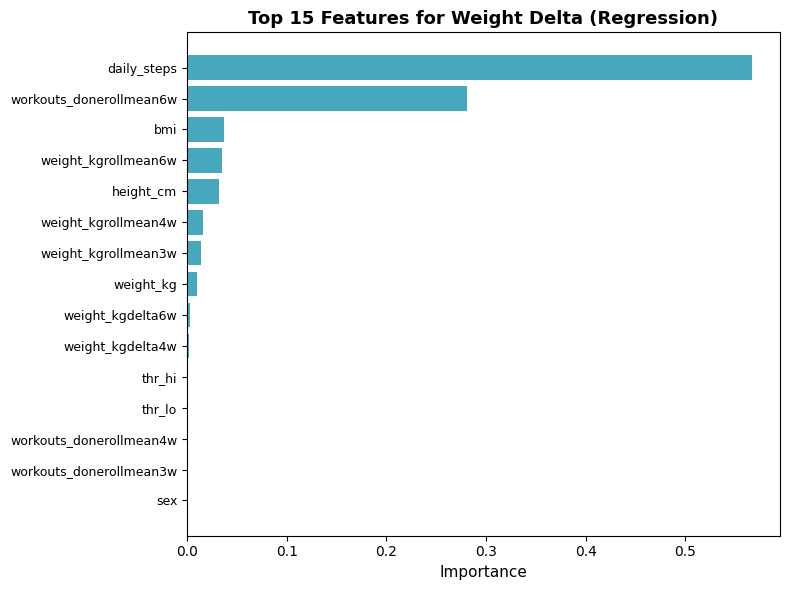

📊 Top Features — Classification Model
💾 Saved plot → /content/drive/MyDrive/FitMatchAI/models/feature_importance_classification_v5.png


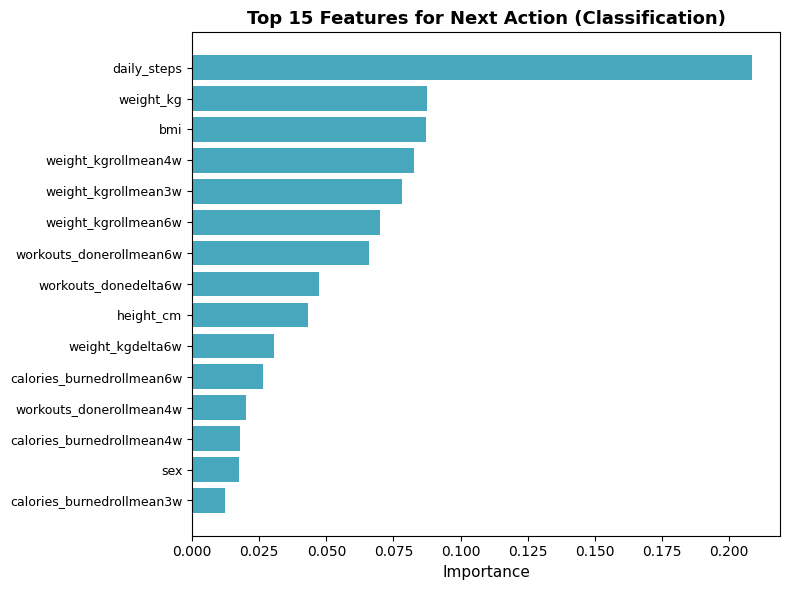

In [ ]:
# ============================
# Section D.2 — Feature Importance Visualization (v5)
# ============================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OrdinalEncoder
import joblib

BASE = Path("/content/drive/MyDrive/FitMatchAI")
DATA_PATH = BASE / "data/processed/enriched_weekly_targets_v5.parquet"
MODEL_DIR = BASE / "models"

# --- Load the dataset for column names ---
df = pd.read_parquet(DATA_PATH)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Encode categoricals (same as during training)
if cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    df[cat_cols] = enc.fit_transform(df[cat_cols])

# Drop IDs and targets
drop_cols = ["user_id","week_idx","label_next_weight_delta","label_next_action"]
X = df.drop(columns=drop_cols, errors="ignore")

# --- Load trained models ---
rf_reg = joblib.load(MODEL_DIR / "rf_regressor_v5.pkl")
rf_cls = joblib.load(MODEL_DIR / "rf_classifier_v5.pkl")

# --- Function to plot top N feature importances ---
def plot_feature_importances(model, X, title, top_n=15, save_name=None):
    """
    Plot top_n feature importances for a trained Random Forest model.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    features = X.columns[indices]
    values = importances[indices]

    plt.figure(figsize=(8,6))
    plt.barh(range(len(indices)), values[::-1], color="#47A8BD")
    plt.yticks(range(len(indices)), features[::-1], fontsize=9)
    plt.xlabel("Importance", fontsize=11)
    plt.title(title, fontsize=13, weight="bold")
    plt.tight_layout()

    if save_name:
        plt.savefig(MODEL_DIR / save_name, dpi=300, bbox_inches="tight")
        print(f"💾 Saved plot → {MODEL_DIR / save_name}")
    plt.show()

# --- Plot importances ---
print("📊 Top Features — Regression Model")
plot_feature_importances(
    rf_reg, X,
    title="Top 15 Features for Weight Delta (Regression)",
    save_name="feature_importance_regression_v5.png"
)

print("📊 Top Features — Classification Model")
plot_feature_importances(
    rf_cls, X,
    title="Top 15 Features for Next Action (Classification)",
    save_name="feature_importance_classification_v5.png"
)

#1) Load teacher, finding a source DataFrame

In [ ]:
import pandas as pd, numpy as np
# Expect your main dataset in DF and label in y (rename below if different)

def pick(cols):
    return next((c for c in cols if c in DF.columns), None)

age   = pick(["age","user_age"])
h     = pick(["height","height_cm"])
w     = pick(["weight","weight_kg"])
bmi   = pick(["bmi"])
goalI = pick(["goal_type","goal_id","target_goal_id"])
goalS = pick(["goal","goal_name","target_goal","program_goal"])
wpw   = pick(["workouts_per_week","sessions_per_week","workouts_done"])
kcal  = pick(["calories_avg","daily_calories","kcal_avg","avg_daily_calories"])
equip = pick(["equipment","equipment_level","equip","gear"])

GOAL_MAP = {"fatloss":0,"weight_loss":0,"cut":0,"hypertrophy":1,"muscle_gain":1,"bulk":1,"endurance":2,"cardio":2}
def to_goal_type(i_col, s_col):
    if i_col:
        s = pd.to_numeric(DF[i_col], errors="coerce").round().astype("Int64").fillna(1)
        return s.clip(0,2).astype(int)
    if s_col:
        s = DF[s_col].astype(str).str.lower().str.replace(" ","_")
        return s.map(lambda x: GOAL_MAP.get(x,1)).astype(int)
    return pd.Series(1, index=DF.index)  # default hypertrophy

def to_equipment(e_col):
    if e_col:
        s = DF[e_col].astype(str).str.lower().str.strip()
        s = s.replace({"":"gym","na":"gym","nan":"gym","bodyweight":"none",
                       "home":"basic","dumbbells":"basic","resistance_band":"basic"})
        return s.where(s.isin(["none","basic","gym"]), "gym")
    return pd.Series("gym", index=DF.index)

def to_calories(k_col):
    if k_col:
        return pd.to_numeric(DF[k_col], errors="coerce")
    # fallback: average of daily columns if present
    days = [c for c in DF.columns if c.lower().startswith("cal_day")]
    if len(days) >= 3:
        return pd.to_numeric(DF[days], errors="coerce").mean(axis=1)
    return pd.Series(2200.0, index=DF.index)

X8 = pd.DataFrame({
    "age":               pd.to_numeric(DF[age], errors="coerce") if age else 22,
    "height":            pd.to_numeric(DF[h],   errors="coerce") if h   else 170.0,
    "weight":            pd.to_numeric(DF[w],   errors="coerce") if w   else 70.0,
    "bmi":               pd.to_numeric(DF[bmi], errors="coerce") if bmi else 24.0,
    "goal_type":         to_goal_type(goalI, goalS),
    "workouts_per_week": pd.to_numeric(DF[wpw], errors="coerce") if wpw else 3,
    "calories_avg":      to_calories(kcal),
    "equipment":         to_equipment(equip)
})
X8["age"]               = X8["age"].fillna(22).clip(10,100).astype(int)
X8["height"]            = X8["height"].fillna(170.0).clip(120,230)
X8["weight"]            = X8["weight"].fillna(70.0).clip(35,220)
X8["bmi"]               = X8["bmi"].fillna(24.0).clip(10,60)
X8["workouts_per_week"] = X8["workouts_per_week"].fillna(3).clip(0,12).astype(int)
X8["calories_avg"]      = X8["calories_avg"].fillna(2200.0).clip(500,6000)
X8["equipment"]         = X8["equipment"].fillna("gym").astype(str).str.lower()

print("X8 shape:", X8.shape)
X8.head()


X8 shape: (99990, 8)


,age,height,weight,bmi,goal_type,workouts_per_week,calories_avg,equipment
0,56,165.3,54.9,19.6,1,6,2200.0,gym
1,56,165.3,56.8,19.6,1,7,2200.0,gym
2,56,165.3,58.6,19.6,1,7,2200.0,gym
3,56,165.3,60.4,19.6,1,7,2200.0,gym
4,56,165.3,62.2,19.6,1,7,2200.0,gym


In [ ]:
# CELL Y — robust y with NaN-safe fallbacks (run this, then run CELL B)

import numpy as np, pandas as pd

def has_var(col):
    return col in DF.columns and pd.to_numeric(DF[col], errors="coerce").nunique(dropna=True) > 1

y = None

# 1) Prefer 3-class from weight delta (loss/stable/gain)
if has_var("label_next_weight_delta"):
    d = pd.to_numeric(DF["label_next_weight_delta"], errors="coerce")
    y = pd.cut(d, bins=[-np.inf, -0.3, 0.3, np.inf], labels=[0,1,2])  # categorical 0/1/2
    # Fill NaNs to "stable" (1) before casting
    y = y.astype("Int64").fillna(1).astype(int)
    print("y from label_next_weight_delta (3 classes)")

# 2) Else tertiles of difficulty_score
elif has_var("difficulty_score"):
    s = pd.to_numeric(DF["difficulty_score"], errors="coerce")
    # rank to break ties, drop NaN safely
    r = s.rank(method="first")
    y = pd.qcut(r, 3, labels=[0,1,2]).astype(int)
    print("y from difficulty_score tertiles")

# 3) Else load proxy (minutes + workouts), tertiles or median split
else:
    tm  = pd.to_numeric(DF.get("total_minutes", np.nan), errors="coerce").fillna(0)
    wd  = pd.to_numeric(DF.get("workouts_done", np.nan), errors="coerce").fillna(0)
    sm  = pd.to_numeric(DF.get("strength_minutes", np.nan), errors="coerce").fillna(0)
    cm  = pd.to_numeric(DF.get("cardio_minutes", np.nan), errors="coerce").fillna(0)
    hm  = pd.to_numeric(DF.get("hiit_minutes", np.nan), errors="coerce").fillna(0)
    load = (tm*0.4) + (wd*10) + (sm*0.3) + (cm*0.2) + (hm*0.5)

    if load.nunique() > 1:
        r = load.rank(method="first")
        try:
            y = pd.qcut(r, 3, labels=[0,1,2]).astype(int)
            print("y from training-load tertiles")
        except ValueError:
            # not enough unique values for tertiles; use median split
            y = (load > np.nanmedian(load)).astype(int)
            print("y from training-load median split (2 classes)")
    else:
        # truly no variance; derive from goal_type/workouts_per_week
        gt  = pd.to_numeric(DF.get("goal_type", 1), errors="coerce").fillna(1).clip(0,2).astype(int)
        wpw = pd.to_numeric(DF.get("workouts_per_week", 3), errors="coerce").fillna(3).clip(0,12).astype(int)
        band = np.where(wpw >= 5, 2, np.where(wpw >= 3, 1, 0))
        band = np.where(gt==2, np.minimum(band+1, 2), band)
        y = pd.Series(band, index=DF.index).astype(int)
        print("y from goal_type/workouts_per_week heuristic")

# Final sanity: ensure >=2 classes; if not, force median split on goal_type + wpw
vc = pd.Series(y).value_counts().sort_index()
if vc.size < 2:
    gt  = pd.to_numeric(DF.get("goal_type", 1), errors="coerce").fillna(1).clip(0,2).astype(int)
    wpw = pd.to_numeric(DF.get("workouts_per_week", 3), errors="coerce").fillna(3).clip(0,12).astype(int)
    z = gt*10 + wpw
    y = (z > np.median(z)).astype(int)
    print("y fallback: median split on goal_type+workouts_per_week")

print("y value counts:", pd.Series(y).value_counts().to_dict())


y from label_next_weight_delta (3 classes)
y value counts: {2: 96633, 1: 3357}


#2) Build X8 (the 8 features your app sends)

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
import json

# y must be your original classification target (same label you used before)
assert "y" in globals(), "Set your target vector into variable `y`."

num = ["age","height","weight","bmi","goal_type","workouts_per_week","calories_avg"]
cat = ["equipment"]

pre = ColumnTransformer([
    ("num","passthrough",num),
    ("cat",OneHotEncoder(handle_unknown="ignore"),cat)
])

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=20,
    min_samples_split=40,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

pipe = Pipeline([("preproc", pre), ("rf", rf)])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
scores = cross_val_score(pipe, X8, y, cv=cv, scoring="accuracy", n_jobs=-1)
print("CV accuracy mean±std:", scores.mean(), scores.std())

Xtr, Xte, ytr, yte = train_test_split(X8, y, test_size=0.2, stratify=y, random_state=42)
pipe.fit(Xtr, ytr)
print("Holdout accuracy:", pipe.score(Xte, yte))


CV accuracy mean±std: 0.9923142314231423 0.00037954421260416685
Holdout accuracy: 0.9913991399139914
✓ Exported 8-feature pipeline.joblib + feature_schema.json


# Exporting the Model

In [ ]:
# Mount Drive (Colab) and export EXACTLY to /content/drive/MyDrive/FitMatchAI/data/reports
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception:
    pass  # if not in Colab this will just skip

from pathlib import Path
from joblib import dump
import json

TARGET_DIR = Path("/content/drive/MyDrive/FitMatchAI/reports")
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Save model + schema
dump(pipe, TARGET_DIR / "pipeline.joblib")
schema = {
    "model_version":"v1",
    "features":["age","height","weight","bmi","goal_type","workouts_per_week","calories_avg","equipment"],
    "types":["int","float","float","float","int","int","float","str"]
}
(TARGET_DIR / "feature_schema.json").write_text(json.dumps(schema, indent=2))

# Verify
print("Saved files:", [p.name for p in TARGET_DIR.iterdir() if p.is_file()])


Mounted at /content/drive
Saved files: ['pipeline.joblib', 'feature_schema.json']
